In [ ]:
# !git clone https://github.com/Changyoon-Lee/big_contest.git

Cloning into 'big_contest'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 360 (delta 0), reused 3 (delta 0), pack-reused 356
Receiving objects: 100% (360/360), 130.76 MiB | 24.60 MiB/s, done.
Resolving deltas: 100% (167/167), done.
Checking out files: 100% (230/230), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
tf.__version__

from datetime import datetime, timedelta
import pickle
from sklearn.model_selection import cross_validate

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
with open('/content/drive/My Drive/빅콘/merged_dataframe.pickle', 'rb') as f:
    data = pickle.load(f)

## 전체적으로 예측

In [ ]:
data.columns

Index(['역명', '역명_label', 'date', '시간', '시간_label', '하차', '승차', '요일',
       '요일_label', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
       '검색트랜드', '평균하차수'],
      dtype='object')

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
data['date_month'] = data['date'].dt.month

In [ ]:
# 23, 43, 131

In [ ]:
data_ = data[data['역명_label'] != 23]
data_ = data_[data_['역명_label'] != 43]
data_ = data_[data_['역명_label'] != 131]
len(data), len(data_), len(data)-580*3

(417980, 416240, 416240)

In [ ]:
numeric_columns = ['공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label','시간_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
cols = numeric_columns + cgr_columns +['하차']

In [ ]:
test =  data_[data_['date_month'] == 5]
train = data_[data_['date_month'] != 5]
train, test = train[cols],test[cols]
y_train, X_train = train['하차'] , train.drop('하차',axis=1)
y_test, X_test = test['하차'] , test.drop('하차',axis=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((309600, 9), (309600,), (106640, 9), (106640,))

In [ ]:
lin_reg = LinearRegression()
X_train_ready = df_pipeline.fit_transform(X_train)
lin_reg.fit(X_train_ready, y_train)
cv = cross_validate(lin_reg, X_train, y_train, cv=5)
cv

{'fit_time': array([0.09387779, 0.06672931, 0.06807613, 0.07005858, 0.07040381]),
 'score_time': array([0.00559855, 0.00518155, 0.0050385 , 0.00499177, 0.00502729]),
 'test_score': array([0.94107909, 0.92374318, 0.94808674, 0.94650908, 0.92780706])}

In [ ]:
cv['test_score'].mean()

0.9374450300727121

In [ ]:
# ls = pd.DataFrame(X_train_ready).columns
new = pd.DataFrame.sparse.from_spmatrix(X_train_ready)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,1.527525,0.0,-0.873567,-0.634622,-0.750989,0.070976,-0.595318,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.527525,0.0,-0.873567,-0.634622,-0.750989,0.070976,-0.405875,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.527525,0.0,-0.873567,-0.634622,-0.750989,0.070976,-0.376532,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.527525,0.0,-0.873567,-0.634622,-0.750989,0.070976,-0.171233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.527525,0.0,-0.873567,-0.634622,-0.750989,0.070976,-0.103693,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_train[:5]

,공휴일,주말제외공휴일,corona_stage,행정구역_확진자,전국_확진자,검색트랜드,평균하차수,요일_label,시간_label
0,1,0,0,0,0.0,0.986268,81.875,5,15
1,1,0,0,0,0.0,0.986268,311.875,5,16
2,1,0,0,0,0.0,0.986268,347.500,5,17
3,1,0,0,0,0.0,0.986268,596.750,5,18
4,1,0,0,0,0.0,0.986268,678.750,5,19


In [ ]:
X_train.describe()

,공휴일,주말제외공휴일,corona_stage,행정구역_확진자,전국_확진자,검색트랜드,평균하차수,요일_label,시간_label
count,309600.000000,309600.0,309600.000000,309600.000000,309600.000000,309600.000000,309600.000000,309600.000000,309600.000000
mean,0.300000,0.0,1.211111,2.098062,832.188889,0.969388,804.642185,3.033333,9.500000
std,0.458258,0.0,1.386400,3.306009,1108.126240,0.237824,1214.087921,1.985786,5.766291
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.000000,0.000000,67.000000,0.839861,218.000000,1.000000,4.750000
50%,0.000000,0.0,0.000000,1.000000,521.000000,0.941013,443.625000,3.000000,9.500000
75%,1.000000,0.0,3.000000,3.000000,803.000000,1.078920,891.000000,5.000000,14.250000
max,1.000000,0.0,3.000000,22.000000,4067.000000,3.430838,20552.500000,6.000000,19.000000


In [ ]:
importance = lin_reg.coef_

array([-120.99822286,    0.        ,   36.62834745,  -15.63580486,
        -55.65686534,   12.98700605, 1086.18149412,  -44.20184508,
        -86.63239295,  -66.21035987,  -41.05079621,  146.32395375,
        164.66723174,  -72.89579137,   -5.07713776,  -39.43704937,
        -48.51029806,  -46.65525773,  -41.04368175,  -39.70198361,
        -44.20795668,  -20.39054065,   32.63754603,   22.77076677,
          7.16617242,   -8.8892828 ,  -18.63962493,  -11.94270861,
        -22.97218566,    9.44210855,   29.94666446,   74.11196261,
        105.9300592 ,   65.46242756])

## Regression : 기준점 (승차 X, 평균하차수만)
- 승차 X (train :0.8996, test: 0.8599)
- 평균하차수(train :0.9289, test: 0.8607)

In [ ]:
score_train, score_test = [],[]
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['평균하차수','하차']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  # X_train_ready = df_pipeline.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  score_train.append(lin_reg.score(X_train, y_train))
  # X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(lin_reg.score(X_test, y_test))

In [ ]:
np.mean(score_train),np.mean(score_test)

(0.8996396161542967, 0.8599245448594858)

In [ ]:
y_hat = lin_reg.predict(X_test)

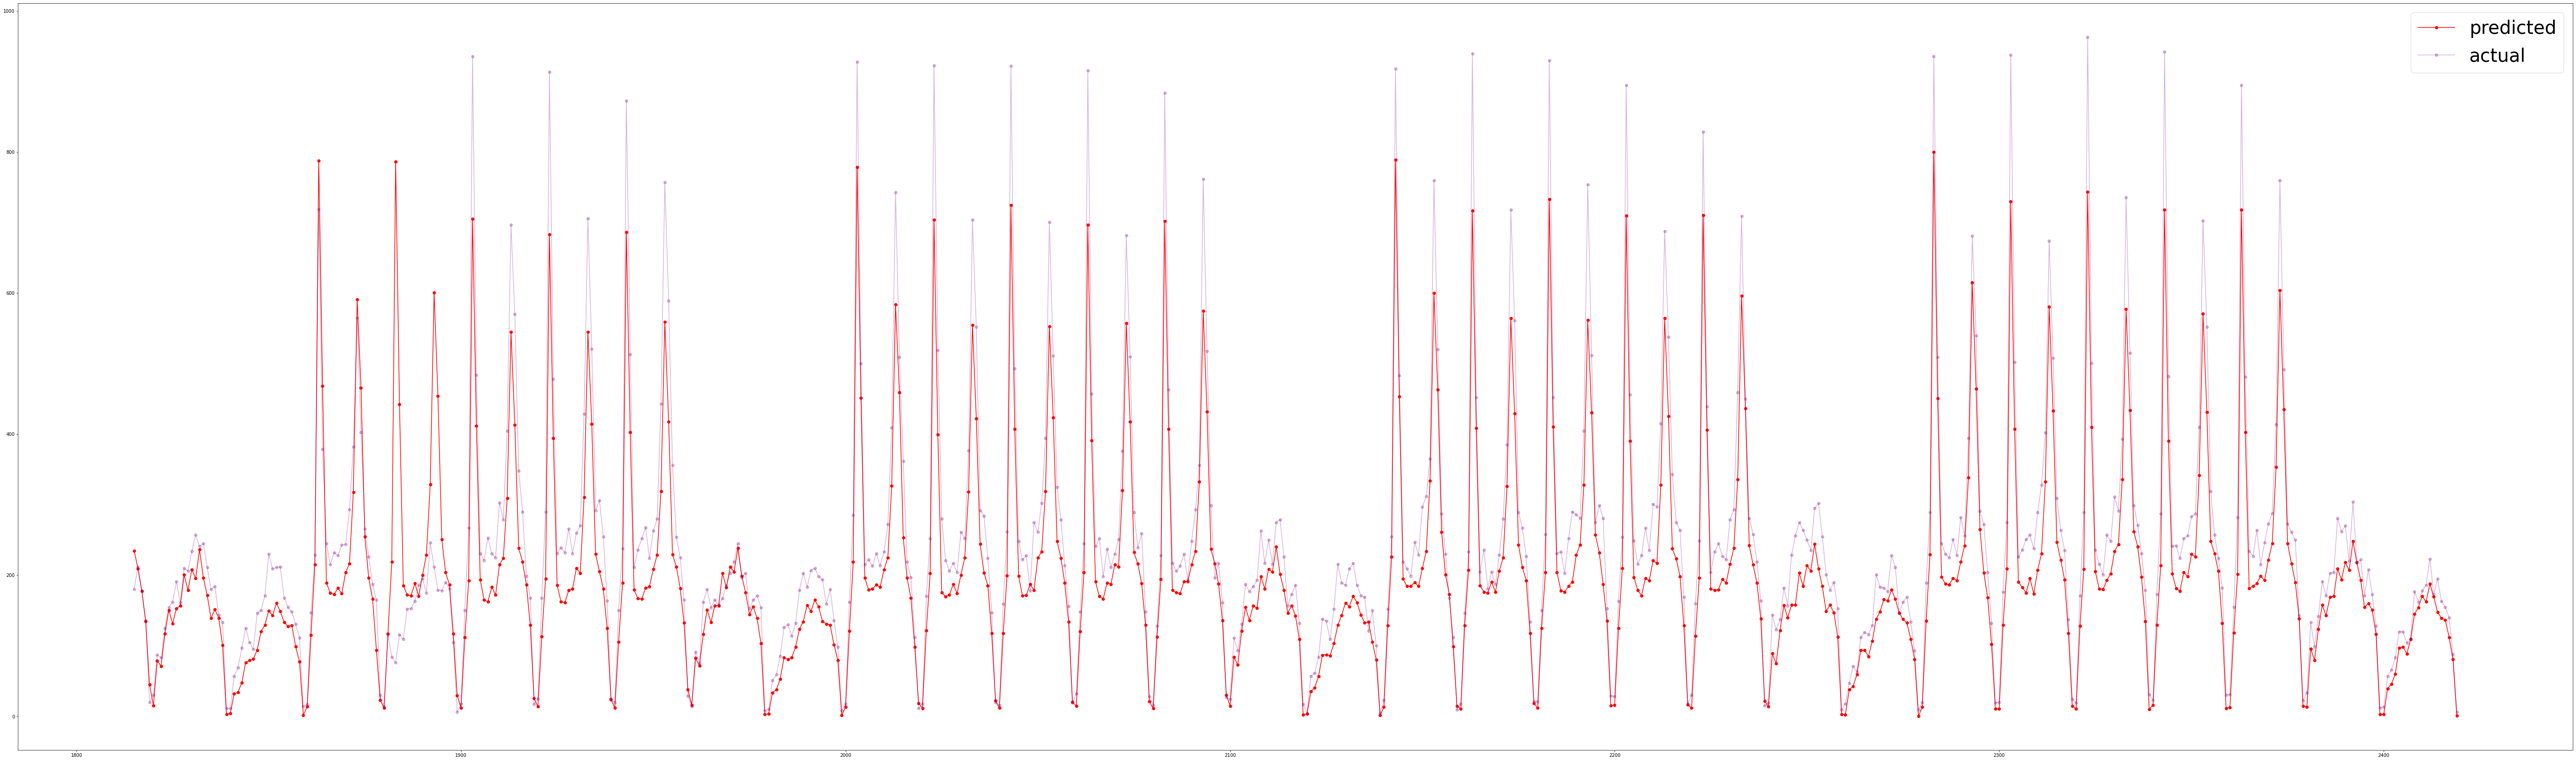

In [ ]:
# y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(100,30))
# plt.plot(y_axis, y_train, '-o') #Train데이터 그래프로 표현
plt.plot(y_2_axis, y_hat, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test, '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=40)
plt.show()

In [ ]:
y_hat[:5], y_test[:5]

(array([45651.55378283, 40863.45200327, 34905.90601027, 26918.38138262,
        10148.99266158]), 417375    180
 417376    212
 417377    178
 417378    136
 417379     20
 Name: 하차, dtype: int64)

In [ ]:
##승차 없애고

In [ ]:
numeric_columns = ['공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label','시간_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
score_train, score_test = [],[]

In [ ]:
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
        '검색트랜드', '평균하차수','요일_label','하차','시간_label']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  print(X_train.shape)
  X_train_ready = df_pipeline.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_train_ready, y_train)
  score_train.append(lin_reg.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(lin_reg.score(X_test_ready, y_test))

(1815, 9)


In [ ]:
np.mean(score_train),np.mean(score_test)

(0.9288664440845965, 0.8606815480515793)

In [ ]:
y_hat = lin_reg.predict(X_test_ready)

In [ ]:
# y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(100,30))
# plt.plot(y_axis, y_train, '-o') #Train데이터 그래프로 표현
plt.plot(y_2_axis, y_hat, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test, '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=40)
plt.show()

# Regression Model
- 시간라벨 X : train: 0.928, test: 0.872
- 시간라벨 O : train: 0.939, test: 0.884

In [ ]:
numeric_columns = ['승차', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
score_train, score_test = [],[]

In [ ]:
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['승차','공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
        '검색트랜드', '평균하차수','요일_label','하차']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_train_ready, y_train)
  score_train.append(lin_reg.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(lin_reg.score(X_test_ready, y_test))

In [ ]:
prac.columns

Index(['승차', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자', '검색트랜드',
       '평균하차수', '요일_label', '하차'],
      dtype='object')

In [ ]:
lin_reg.coef_

array([ 5.21986364e+01, -3.56740913e+01, -8.52651283e-14,  3.63190655e+00,
       -8.33254957e-01, -1.28088140e+01, -2.82346414e+00,  1.31333233e+02,
       -2.39616019e+01, -2.53975809e+01, -1.93532510e+01, -1.44101055e+01,
        5.29069435e+01,  5.32783603e+01, -2.30627646e+01])

In [ ]:
# y에 대한 분포
# sns.distplot(prac['하차'], rug=True, rug_kws={'alpha': 0.05})
# stats.probplot(prac['하차'], plot=plt)

In [ ]:
np.mean(score_train),np.mean(score_test)

(0.9279874903620878, 0.8724320758653994)

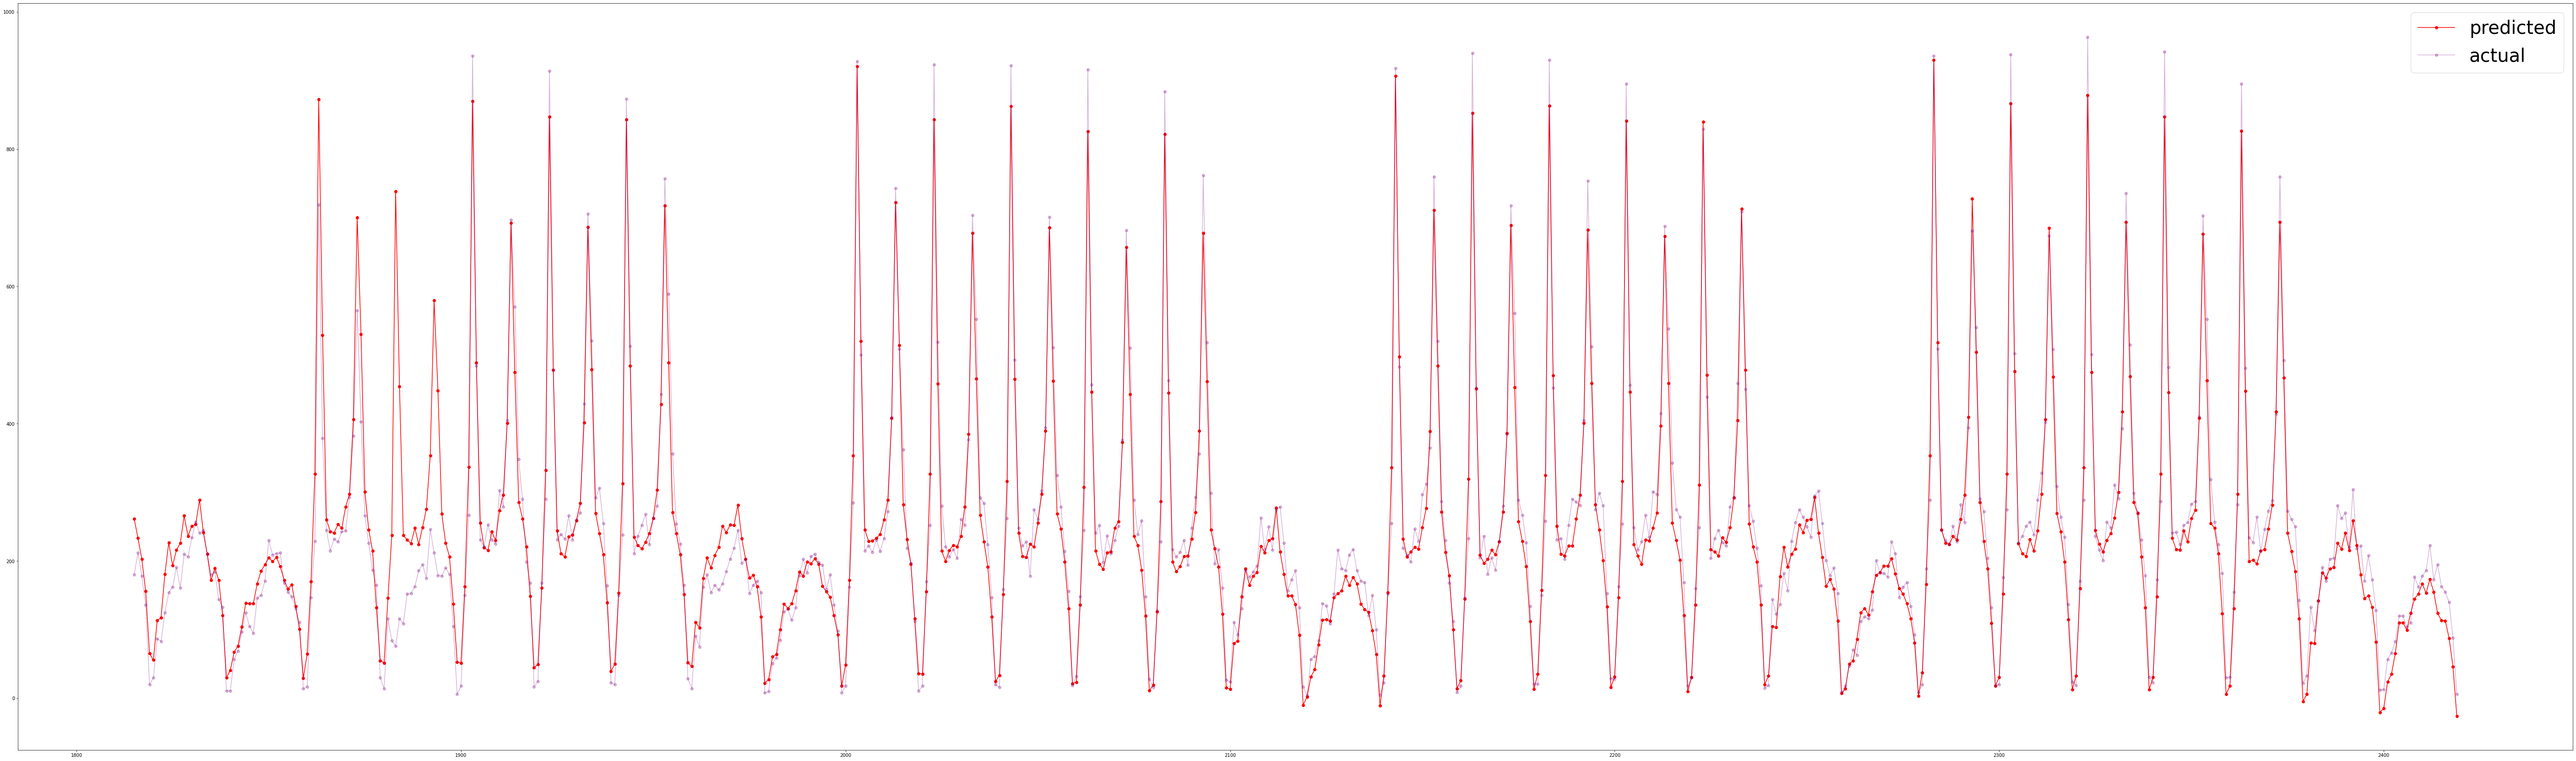

In [ ]:
# y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(100,30))
# plt.plot(y_axis, y_train, '-o') #Train데이터 그래프로 표현
plt.plot(y_2_axis, y_hat, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_test, '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
plt.legend(fontsize=40)
plt.show()

###시간데이터 label 추가

In [ ]:
numeric_columns = ['승차', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label','시간_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
score_train, score_test = [],[]
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['승차','시간_label','공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
        '검색트랜드', '평균하차수','요일_label','하차']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  lin_reg = LinearRegression()
  lin_reg.fit(X_train_ready, y_train)
  score_train.append(lin_reg.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(lin_reg.score(X_test_ready, y_test))

In [ ]:
np.mean(score_train),np.mean(score_test)

(0.9390231113193638, 0.8842793250400512)

# Random Forest Regressor
(0.9702619202201322, 0.9025051341560678)
- 시간라벨 X : train: 0.970, test: 0.902
- 시간라벨 O : train: 0.972, test: 0.904

In [ ]:
numeric_columns = ['승차', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label','시간_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
score_train, score_test = [],[]
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['승차','시간_label','공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
        '검색트랜드', '평균하차수','요일_label','하차']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  forest = RandomForestRegressor(max_depth=5)
  forest.fit(X_train_ready, y_train)
  score_train.append(forest.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(forest.score(X_test_ready, y_test))

In [ ]:
np.mean(score_train),np.mean(score_test) #8

(0.9719002318902322, 0.904607190885942)

In [ ]:
numeric_columns = ['승차', '공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자','검색트랜드', '평균하차수']
cgr_columns = ['요일_label']
numeric_pipeline = Pipeline([
                             ('scaler', StandardScaler()
                             )])
cgr_pipeline = Pipeline([
                         ('onehot', OneHotEncoder())
                         ])
df_pipeline = ColumnTransformer([
                                 ('num_pipeline', numeric_pipeline, numeric_columns),
                                 ('cgr_pipeline', cgr_pipeline, cgr_columns)
])

In [ ]:
score_train, score_test = [],[]
for i in tqdm(range(175)):
  prac = data[data['역명_label']==i]  
  prac = prac[['승차','시간_label','공휴일', '주말제외공휴일', 'corona_stage', '행정구역_확진자', '전국_확진자',
        '검색트랜드', '평균하차수','요일_label','하차']]
  y = prac['하차']
  X = prac.drop('하차',axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=False)
  X_train_ready = df_pipeline.fit_transform(X_train)
  forest = RandomForestRegressor(max_depth=5)
  forest.fit(X_train_ready, y_train)
  score_train.append(forest.score(X_train_ready, y_train))
  X_test_ready = df_pipeline.fit_transform(X_test)
  score_test.append(forest.score(X_test_ready, y_test))

In [ ]:
np.mean(score_train),np.mean(score_test) #5

(0.9702452569623503, 0.9020317266946408)

## Time series

In [ ]:
with open('/content/drive/My Drive/빅콘/data_timeseries_all.pickle', 'rb') as f:
    time_series_all = pickle.load(f)

In [ ]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
from fbprophet import Prophet

prophet = Prophet()

In [ ]:
subway = time_series_all[time_series_all['역명_label']==0].reset_index(drop=True)
subway = subway[['new_date','하차']]
subway.columns = ['ds','y']

In [ ]:
X_train = subway[:2160] # 5월 기준
X_test = subway[2160:]

In [ ]:
prophet.fit(X_train)

In [ ]:
days = 31 #예측월의 일수
future = prophet.make_future_dataframe(periods=days*24,freq='H')
forecast = prophet.predict(future)
y_hat = forecast.iloc[len(forecast)-len(X_train):].yhat

In [ ]:
# # y_axis = np.arange(0, len(y_train))
# y_2_axis = np.arange(len(X_train), len(X_train) + len(y_hat))

# plt.figure(figsize=(100,30))
# # plt.plot(y_axis, y_train, '-o') #Train데이터 그래프로 표현
# plt.plot(y_2_axis, y_hat, '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
# plt.plot(y_2_axis, X_test['y'], '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현 
# plt.legend(fontsize=40)
# plt.show()

KeyError: ignored

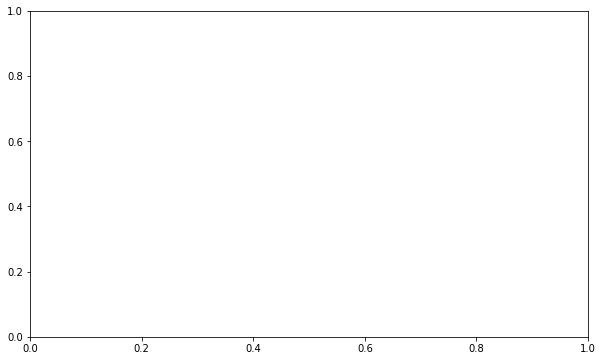

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(forecast, metric='mape')
fig

# LSTM

In [ ]:
with open('/content/drive/My Drive/빅콘/data_timeseries.pickle', 'rb') as f:
    time_series = pickle.load(f)

In [ ]:
subway = time_series[time_series['역명_label']==0] 
subway = np.array(subway['하차'])
subway = (subway-subway.mean(axis=0))/subway.std(axis=0)
time_step = 20 #24시간 기준
days = 31 #마지막월
X = np.array([[[subway[i+j]] for j in range(time_step)] for i in range(len(subway)-time_step)])
y = np.array([[subway[i+time_step]] for i in range(len(subway)-time_step)])
# x_train, x_test, y_train, y_test =  train_test_split(X, y, shuffle=False, test_size=days*time_step)
# model = tf.keras.Sequential()
# model.add(layers.LSTM(20, return_sequences=True))
# model.add(layers.Dropout(0.2)) # 규제 (레이어간)
# model.add(layers.LSTM(10, return_sequences=True))
# model.add(layers.Dropout(0.2))
# model.add(layers.LSTM(5, recurrent_dropout=0.2))
# model.add(layers.Dense(1))

# model.compile(optimizer=tf.keras.optimizers.RMSprop(),
#                 loss='mse')
# model.fit(x_train, y_train, epochs=100, verbose=0)
# model.evaluate(x_test, y_test, batch_size = 30)

In [ ]:
X.shape, y.shape

((2400, 20, 1), (2400, 1))

In [ ]:
X[0]

array([[-1.13923968],
       [-0.74571211],
       [-0.69487362],
       [-0.30511186],
       [-0.11682116],
       [-0.08669464],
       [ 0.01309943],
       [ 0.1656149 ],
       [ 0.21457048],
       [ 0.18820979],
       [ 0.51018689],
       [ 0.36143723],
       [ 0.74743318],
       [ 0.48006038],
       [-0.00384673],
       [-0.41432047],
       [-0.45762733],
       [-0.57060175],
       [-0.66851292],
       [-1.07710375]])

In [ ]:
y[0]

array([-1.27480899])

In [ ]:
score_list = []

In [ ]:
for i in tqdm(range(175)):
  subway = prac[prac['역명_label']==i] 
  subway = np.array(subway['하차'])
  subway = (subway-subway.mean(axis=0))/subway.std(axis=0)
  time_step = 20 #24시간 기준
  days = 31 #마지막월
  X = np.array([[[subway[i+j]] for j in range(time_step)] for i in range(len(subway)-time_step)])
  y = np.array([[subway[i+time_step]] for i in range(len(subway)-time_step)])
  x_train, x_test, y_train, y_test =  train_test_split(X, y, shuffle=False, test_size=days*time_step)
  model = tf.keras.Sequential()
  model.add(layers.LSTM(20, return_sequences=True))
  model.add(layers.Dropout(0.2)) # 규제 (레이어간)
  model.add(layers.LSTM(10, return_sequences=True))
  model.add(layers.Dropout(0.2))
  model.add(layers.LSTM(5, recurrent_dropout=0.2))
  model.add(layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='mse')
  model.fit(x_train, y_train, epochs=100, verbose=0)
  score_list.append(model.evaluate(x_test, y_test, batch_size = 30))
np.mean(score_list)

21/21 [==============================] - 0s 11ms/step - loss: 0.2734


In [ ]:
# y_hat = model.predict(x_test)
# y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

# plt.figure(figsize=(15,10))
# plt.plot(y_2_axis, y_hat.reshape(-1,), '-o', color='red', label='predicted')
# plt.plot(y_2_axis, y_test.reshape(-1,), '-o', color='purple', alpha=0.15, label='actual') 
# plt.legend()
# plt.show()